In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

# Bước 1: Load dữ liệu

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0CM11M/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0CM11M/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0CM11M/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b"At the end of this episode Holmes asks Watson not to record the case for posterity.For a good reason! The super sleuth left his little grey cells(sorry Agatha)at home for this tale. There is no deductive reasoning,no acute analysis of signs at crime scenes. Holmes bumbles along fifty yards behind the plot. The dastardly CAM is finally dealt to by an old frail-in a manner that would have made Charles Bronson's heart swell with pride-six bullets in the breadbasket.In an ensuing chase a pursuer gets hold of one of Watson's shoes.Mercifully the writer didn't decide to tack on the story of Cinderella to lengthen the film.The murderess,Holmes and Watson,escape scot free. Oh well,it is a bit of a change of pace in late Victorian London.A bit of sixgun law:-)"
 b'Paris is the place to be to enjoy beautiful art and music, and to fall madly in love - as is the case in this film. Boy meets girl, they fall in love, but something stands in their way of eternal happiness, the classic stor

# Bước 2: Text Encoder

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 31,   2, 129, ...,   0,   0,   0],
       [  1,   7,   2, ...,   0,   0,   0],
       [  1,   1,   3, ...,   0,   0,   0]])

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 31,   2, 129, ...,   0,   0,   0],
       [  1,   7,   2, ...,   0,   0,   0],
       [  1,   1,   3, ...,   0,   0,   0]])

# Bước 3: build model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

In [14]:
history = model.fit(train_dataset, epochs=5, \
                    validation_data=test_dataset, \
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 110s 248ms/step - loss: 0.6628 - accuracy: 0.5460 - val_loss: 0.5459 - val_accuracy: 0.7135
Epoch 2/5
391/391 [==============================] - 94s 238ms/step - loss: 0.5757 - accuracy: 0.6912 - val_loss: 0.5612 - val_accuracy: 0.7276
Epoch 3/5
391/391 [==============================] - 94s 238ms/step - loss: 0.5104 - accuracy: 0.7299 - val_loss: 0.4710 - val_accuracy: 0.7729
Epoch 4/5
391/391 [==============================] - 93s 234ms/step - loss: 0.4276 - accuracy: 0.7983 - val_loss: 0.3971 - val_accuracy: 0.8276
Epoch 5/5
391/391 [==============================] - 93s 235ms/step - loss: 0.3731 - accuracy: 0.8360 - val_loss: 0.3618 - val_accuracy: 0.8422


In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 48s 123ms/step - loss: 0.3557 - accuracy: 0.8451
Test Loss: 0.35571154952049255
Test Accuracy: 0.8451200127601624


(0.0, 0.6778299510478973)

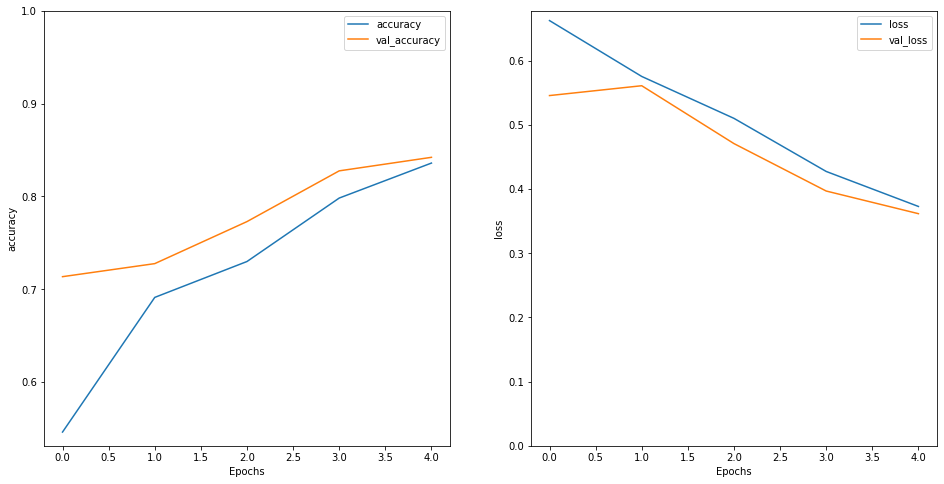

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Stacking

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), \
              optimizer=tf.keras.optimizers.Adam(1e-4), \
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
391/391 [==============================] - 193s 461ms/step - loss: 0.6178 - accuracy: 0.5989 - val_loss: 0.4196 - val_accuracy: 0.8135
Epoch 2/5
391/391 [==============================] - 175s 444ms/step - loss: 0.3760 - accuracy: 0.8350 - val_loss: 0.3538 - val_accuracy: 0.8484
Epoch 3/5
391/391 [==============================] - 169s 430ms/step - loss: 0.3355 - accuracy: 0.8566 - val_loss: 0.3554 - val_accuracy: 0.8583
Epoch 4/5
391/391 [==============================] - 171s 436ms/step - loss: 0.3200 - accuracy: 0.8609 - val_loss: 0.3564 - val_accuracy: 0.8281
Epoch 5/5
391/391 [==============================] - 171s 434ms/step - loss: 0.3129 - accuracy: 0.8665 - val_loss: 0.3318 - val_accuracy: 0.8615


In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 87s 221ms/step - loss: 0.3318 - accuracy: 0.8631
Test Loss: 0.3318386673927307
Test Accuracy: 0.8631200194358826


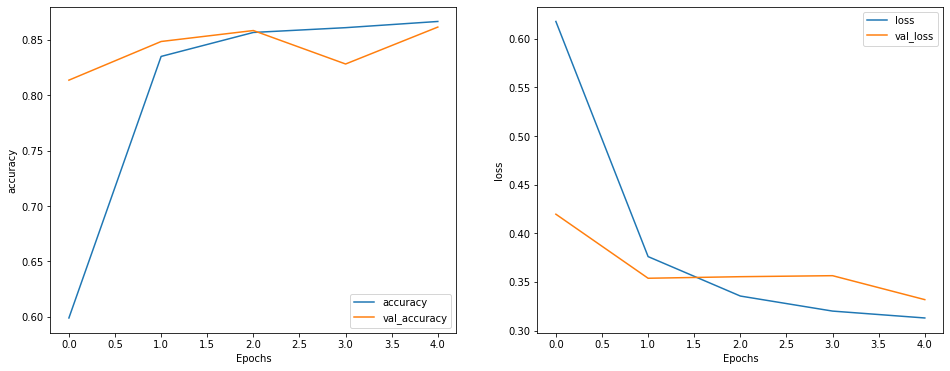

In [23]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')